# LC$^2$ Similarity Metric for Multi-Modal Registration

This notebook contains a step-wise implementation of the patch-wise LC$^2$ similarity metric for multi-modal registration of 2D images.

### 1) Least-squares solution for relation function $f$
The LC$^2$-metric linearly combines the MR image and its gradient magnitude image using relationship function $f$, which is based on the least-squares solution. We first implement a Numba function for finding the least-squares solution.

In [1]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, vectorize

(-0.5, 17.5, 17.5, -0.5)

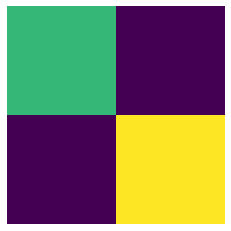

In [2]:
# create test images
c1 = np.zeros((18,18), dtype=np.float64)
c1[0:9, 0:9] = 1.0

c2 = np.zeros((18,18), dtype=np.float64)
c2[9:18, 9:18] = 1.0

img1 = 2*c1 + 3*c2

# show the image
plt.imshow(img1)
plt.axis('off')

In [3]:
@njit
def least_squares_solution(A, b):
    """
    Find the least-squares solution for a linear system of equations Ax = b.
    :param A: Matrix A with equations
    :param b: Vector b with targets
    :return: x
    """
    x = np.dot(np.linalg.pinv(np.dot(A.T, A)), np.dot(A.T, b))
    return x

In [4]:
@njit
def combine_MR_channels(us, mr, mr_gm, ids):
    """
    Reshape the images and find the least-squares solution between the US image and the MR channels.
    :param us: US image
    :param mr: MR image
    :param mr_gm: Gradient magnitude of MR image
    :param ids: Indices of all non-zero elements
    :return: A, x, b
    """
    A = np.concatenate((mr.reshape(-1, 1), mr_gm.reshape(-1, 1), np.zeros_like(mr).reshape(-1, 1)), 1)[ids,:]
    b = us.reshape(-1, 1)[ids,:]
    x = least_squares_solution(A, b)
    return A, x, b

Shape of A: (324, 3)
Shape of b: (324, 1)
Parameters x using Numba implementation:
 [[2.]
 [3.]
 [0.]]
Parameters x using SciPy implementation:
 [[2.]
 [3.]
 [0.]]
Difference:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.

(-0.5, 17.5, 17.5, -0.5)

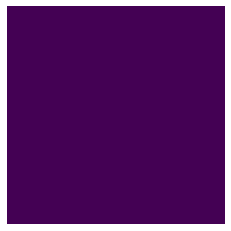

In [5]:
from scipy.linalg import lstsq

A, x, b = combine_MR_channels(img1, c1, c2, np.arange(img1.size))

print('Shape of A:', A.shape)
print('Shape of b:', b.shape)
print('Parameters x using Numba implementation:\n', x)
print('Parameters x using SciPy implementation:\n', lstsq(A, b)[0])
print('Difference:\n',(np.dot(A, x)-b).reshape(18, 18))

plt.imshow((np.dot(A, x)-b).reshape(18, 18))
plt.axis('off')

In [6]:
# alternative computation for comparison (which was used in previous implementation)
@njit
def alternative_least_squares_solution(A, b):
    """
    Find the least-squares solution for a linear system of equations Ax = b.
    :param A: Matrix A with equations
    :param b: Vector b with targets
    :return: x
    """
    x = np.dot(np.linalg.pinv(A), b)
    return A, x, b

print(alternative_least_squares_solution(A, b)[1])

[[2.]
 [3.]
 [0.]]


In [7]:
%%time
for _ in range(100000):
    least_squares_solution(A, b)    

Wall time: 1.24 s


In [8]:
%%time
for _ in range(100000):
    alternative_least_squares_solution(A, b)  

Wall time: 2.05 s


Note that the alternative implementation is substantially slower (especially for large image/patch sizes).

## 2) Calculating the LC$^2$ similarity metric
Now that we have the functions for reshaping the images and calculating the least-squares solution, we can compute the similarity metric.

In [9]:
@njit
def LC2_metric(us, mr, mr_gm):
    """
    Computes the LC2 similarity metric for the entire image. 
    :param us: US image
    :param mr: MR image
    :param mr_gm: Gradient magnitude of MR image
    :return: LC2, weight
    """    
    # initialize variables
    LC2 = 0.0
    weight = 0.0
    
    # find all non-zero elements in the ultrasound image
    ids = np.flatnonzero(us)

    # at least two non-zero elements are required for calculating the variance 
    if len(ids) > 1:
        
        # calculate the variance of all non-zero elements in the ultrasound image
        U_var = np.var(us.flatten()[ids])
        
        # check if the variance is non-zero to prevent division by zero errors
        if U_var > 1e-12:
    
            # make sure the arrays are contiguous
            us = np.ascontiguousarray(us)
            mr = np.ascontiguousarray(mr)
            mr_gm = np.ascontiguousarray(mr_gm)
    
            # flatten the images and find the weights for combining the MR channels
            M, c, U = combine_MR_channels(us, mr, mr_gm, np.arange(us.size))
            
            # calculate the LC2
            LC2 = 1 - (np.sum((U-np.dot(M, c))**2) / (len(ids)*U_var))
            weight = np.sqrt(U_var)
    
    return LC2, weight

Now we can check if the implementation of the LC2 metric follows what we would expect.

In [10]:
# define function for computing the gradient magnitude of an image

def gradient_magnitude(img):
    """
    Computes the gradient magnitude of an image.
    :param img:  2D image
    :return: gradient_magnitude
    """
    grad_y, grad_x = np.gradient(img)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    return gradient_magnitude

(-0.5, 255.5, 255.5, -0.5)

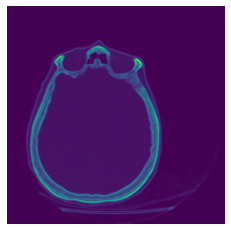

In [11]:
from skimage.data import brain

# load example brain image
brain = brain()[0, ...]
brain = brain/np.max(brain)
brain_gm = gradient_magnitude(brain)

# create a linear combination of the two images
target_image = brain*1.5 + brain_gm*8

plt.imshow(target_image)
plt.axis('off')

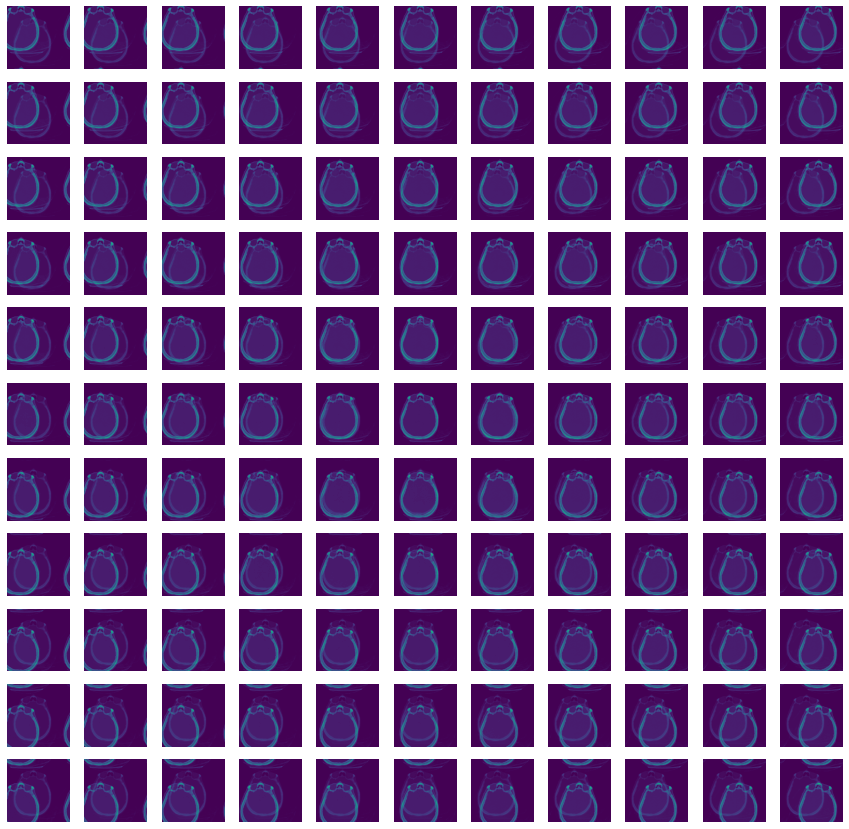

In [12]:
fig, ax = plt.subplots(11,11, figsize=(15,15))

# allocate memory to store LC2 results
LC2_results = np.zeros((11, 11))

# loop over x and y shifts of the target image
for i, x in enumerate(range(-50, 51, 10)):
    for j, y in enumerate(range(-50, 51, 10)):
        
        # shift the target image
        shifted_target = np.roll(np.roll(target_image, y, 0), x, 1)
        
        LC2, _ = LC2_metric(shifted_target, brain, brain_gm)
        LC2_results[j,i] = LC2
                
        ax[j,i].imshow(0.5*shifted_target+0.5*brain)
        
for x in ax.ravel():
    x.axis('off')

Max: 1.0, Min:-0.161
Weights:
 [[1.5]
 [8. ]
 [0. ]]


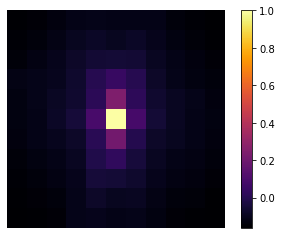

In [13]:
plt.imshow(LC2_results, cmap='inferno')
plt.axis('off')
plt.colorbar()

print(f'Max: {np.max(LC2_results)}, Min:{np.min(LC2_results):0.3f}')

print('Weights:\n',combine_MR_channels(target_image, brain, brain_gm, np.arange(target_image.size))[1])

Notice that the peak in the LC2 similarity metric is in the center, where the target image is not translated with respect to the brain channels. Also notice that the peak has a value of 1, meaning an exact match. If we look at the weights without any translation, we see that these match with the values we selected above to create the target image. If the images are not properly aligned, the similarity value decreases and can go below zero.

## 3) Patch-wise LC$^2$ similarity metric

In [14]:
@vectorize
def clip_below(value, threshold):
    """
    Clips value if below threshold.
    :value: numeric value
    :threshold: numeric threshold
    :returns: value (after clipping)
    """
    if value < threshold:
        value = threshold
    return value

@njit
def LC2_similarity_patch(us, mr, mr_gm, patch_size):
    """
    Computes the patch-wise LC2 similarity metric for the entire image. 
    :param us: US image
    :param mr: MR image
    :param mr_gm: Gradient magnitude of MR image
    :patch_size: size of patch
    :return: LC2_similarity, LC2_map, weight_map
    """
    if patch_size%2 == 0 or patch_size < 1:
        raise ValueError('Invalid patch size')
    
    # define patch-related variable
    offset = patch_size//2

    # define image size related parameters
    max_rows, max_cols = us.shape

    # set all intensity values in the US image below zero to zero 
    us = clip_below(us, 0.0) 

    # allocate memory to store results
    LC2_map = np.zeros(us.shape)
    weight_map = np.zeros(us.shape)

    # loop through all pixels
    for col in range(max_cols):
        for row in range(max_rows):

            # extract patches from us and mr+grad
            us_patch = us[
                max(0, row-offset):min(max_rows, row+offset+1),
                max(0, col-offset):min(max_cols, col+offset+1)
            ]

            mr_patch = mr[
                max(0, row-offset):min(max_rows, row+offset+1),
                max(0, col-offset):min(max_cols, col+offset+1)
            ]
            
            mr_gm_patch = mr_gm[
                max(0, row-offset):min(max_rows, row+offset+1),
                max(0, col-offset):min(max_cols, col+offset+1)
            ]

            LC2_map[row, col], weight_map[row, col] = LC2_metric(us_patch, mr_patch, mr_gm_patch)
    
    if np.sum(weight_map) == 0:
        return 0, LC2_map, weight_map
    else:
        return np.sum(LC2_map*weight_map) / np.sum(weight_map), LC2_map, weight_map

Patch-wise LC2: 1.0


Text(0.5, 1.0, 'weight map')

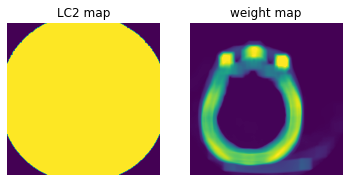

In [15]:
similarity, LC2_map, weight_map = LC2_similarity_patch(target_image, brain, brain_gm, 19)

print('Patch-wise LC2:', similarity)

fig, ax = plt.subplots(1,2, figsize=(6,4))
ax[0].imshow(LC2_map, vmin=0, vmax=1)
ax[0].axis('off')
ax[0].set_title('LC2 map')
ax[1].imshow(weight_map, vmin=0, vmax=1)
ax[1].axis('off')
ax[1].set_title('weight map')

The patch-wise LC$^2$ similarity is also equal to 1.0 for the target image and the brain channels without translations, which is what we would expect. It is interesting to look at the LC2 score and weighting for each pixel. It seems that the LC2 is 1.0 for all pixels in a circular shape, which is likely the region with non-zero pixel values. The weight map, which is the standard deviation of the intensities in a patch in the target image, is largest near the edges of the skull, which are the high contrast regions in head CT.

Horizontal translation: 1px
Patch-wise LC2: 0.775


Text(0.5, 1.0, 'weight map')

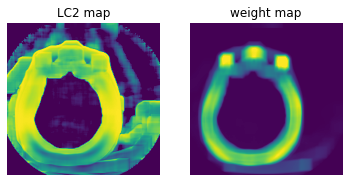

In [16]:
similarity, LC2_map, weight_map = LC2_similarity_patch(np.roll(target_image, 1, 0), brain, brain_gm, 19)

print('Horizontal translation: 1px')
print(f'Patch-wise LC2: {similarity:0.3f}')

fig, ax = plt.subplots(1,2, figsize=(6,4))
ax[0].imshow(LC2_map, vmin=0, vmax=1)
ax[0].axis('off')
ax[0].set_title('LC2 map')
ax[1].imshow(weight_map, vmin=0, vmax=1)
ax[1].axis('off')
ax[1].set_title('weight map')

Horizontal translation: 10px
Patch-wise LC2: -0.202


Text(0.5, 1.0, 'weight map')

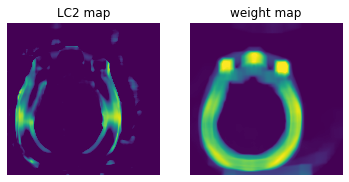

In [17]:
similarity, LC2_map, weight_map = LC2_similarity_patch(np.roll(target_image, 10, 0), brain, brain_gm, 19)

print('Horizontal translation: 10px')
print(f'Patch-wise LC2: {similarity:0.3f}')

fig, ax = plt.subplots(1,2, figsize=(6,4))
ax[0].imshow(LC2_map, vmin=0, vmax=1)
ax[0].axis('off')
ax[0].set_title('LC2 map')
ax[1].imshow(weight_map, vmin=0, vmax=1)
ax[1].axis('off')
ax[1].set_title('weight map')

Similar to what we saw before for the global LC2, when the images are misaligned, the similarity value drops (even more below zero using the patch-based approach). Note that the weight map does not change (disregarding the translation), because it is solely dependant on the ultrasound standard deviation.